In [ ]:
import numpy as np
from typing import List, Tuple, Dict
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import get_critical_contacts


def load_mj_matrix(mj_file_path: str,standardize: bool = False) -> Dict[Tuple[str, str], float]:
    """加载MJ矩阵文件"""
    with open(mj_file_path, 'r') as f:
        lines = f.readlines()
    
    header = lines[0].strip().split()
    amino_acids = header
    n_aa = len(amino_acids)
    
    matrix = np.zeros((n_aa, n_aa))
    for i, line in enumerate(lines[1:]):
        values = line.strip().split()
        for j, value in enumerate(values):
            if value != '0.00e+00':
                matrix[i, j] = float(value)
                matrix[j, i] = float(value)
    
    if standardize:
        scaler = StandardScaler()
        matrix = scaler.fit_transform(matrix)
    
    # 创建查询字典
    mj_dict = {}
    for i, aa1 in enumerate(amino_acids):
        for j, aa2 in enumerate(amino_acids):
            mj_dict[(aa1, aa2)] = matrix[i, j]
            mj_dict[(aa2, aa1)] = matrix[i, j]
    
    return mj_dict


def generate_contact_embedding(msa_path: str,
                      target_contacts: List[Tuple[int, int]],
                      mj_dict: Dict,
                      standardize: bool = True) -> np.ndarray:
    from Bio import SeqIO
    from sklearn.preprocessing import StandardScaler    

    # 读取序列
    sequences = []
    with open(msa_path, 'r') as f:
        for record in SeqIO.parse(f, "fasta"):
            sequences.append(str(record.seq))
    
    m, d = len(sequences), len(target_contacts)s
    X = np.zeros((m, d))
    
    # 构建embedding
    for seq_idx, sequence in enumerate(sequences):
        for contact_idx, (i, j) in enumerate(target_contacts):
            if i < len(sequence) and j < len(sequence):
                res_i, res_j = sequence[i], sequence[j]
                if res_i != '-' and res_j != '-':
                        mj_energy = mj_dict.get((res_i.upper(), res_j.upper()), 0)
                        X[seq_idx, contact_idx] = mj_energy  
    
    # 标准化
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    return X

In [3]:
def gmm_bic_analysis(X: np.ndarray, max_k: int = 10, random_state: int = 42, verbose: bool = True) -> Tuple[List[int], List[float], int]:
    """
    使用高斯混合模型(GMM)拟合数据并计算BIC分数
    
    Args:
        X: 高维向量数据 (n_samples, n_features)
        max_k: 最大聚类数k
        random_state: 随机种子
        verbose: 是否打印详细信息
        
    Returns:
        (k_values, bic_scores, best_k): k值列表、BIC分数列表、最优k值
    """
    from sklearn.mixture import GaussianMixture
    
    k_values = list(range(1, max_k + 1))
    bic_scores = []
    aic_scores = []
    models = []
    
    if verbose:
        print("k\tBIC分数\t\t对数似然")
        print("-" * 35)
    
    for k in k_values:
        # 拟合GMM模型
        gmm = GaussianMixture(
            n_components=k,
            random_state=random_state,
            max_iter=100,
            covariance_type='full'  # 完整协方差矩阵
        )
        
        gmm.fit(X)
        
        # 计算BIC分数
        bic = gmm.bic(X)
        # aic = gmm.aic(X)
        log_likelihood = gmm.score(X) * len(X)  # 总对数似然
        
        bic_scores.append(bic)
        # aic_scores.append(aic)
        models.append(gmm)
        
        if verbose:
            print(f"{k}\t{bic:.2f}\t\t{log_likelihood:.2f}")
    
    # 选择最优k值（BIC最小）
    best_k = k_values[np.argmin(bic_scores)]
    
    if verbose:
        print(f"\n最优k值: {best_k} (BIC = {min(bic_scores):.2f})")
    
    return k_values, bic_scores, best_k


def plot_bic_curve(k_values: List[int], bic_scores: List[float], title: str = "GMM BIC分数曲线"):
    """
    绘制BIC分数曲线
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, bic_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('num of cluster k')
    plt.ylabel('BIC score')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    # 标记最优点
    best_idx = np.argmin(bic_scores)
    plt.plot(k_values[best_idx], bic_scores[best_idx], 'ro', markersize=12, 
             label=f'best k={k_values[best_idx]}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()




def gmm_cluster_analysis(X: np.ndarray, k: int, random_state: int = 42):
    """
    使用指定k值进行GMM聚类分析
    
    Returns:
        (gmm_model, labels, probabilities): GMM模型、聚类标签、后验概率
    """
    from sklearn.mixture import GaussianMixture
    
    gmm = GaussianMixture(
        n_components=k,
        random_state=random_state,
        max_iter=100,
        covariance_type='full'
    )
    
    gmm.fit(X)
    labels = gmm.predict(X)
    probabilities = gmm.predict_proba(X)
    
    return gmm, labels, probabilities

In [3]:
def visualize_point_cloud(X: np.ndarray, 
                         labels: np.ndarray = None,
                         method: str = 'pca',
                         title: str = None,
                         figsize: Tuple[int, int] = (12, 8),
                         alpha: float = 0.7,
                         s: int = 50,
                         random_state: int = 42,
                         # t-SNE参数
                         perplexity: int = 30,
                         n_iter: int = 1000,
                         # UMAP参数
                         n_neighbors: int = 15,
                         min_dist: float = 0.1,
                         metric: str = 'euclidean',
                         save_path: str = None) -> Tuple[np.ndarray, object]:
    """
    对高维数据进行降维可视化
    
    Args:
        X: 高维数据 (n_samples, n_features)
        labels: 聚类标签，可选 (n_samples,)
        method: 降维方法 'pca', 'tsne', 或 'umap'
        title: 图表标题
        figsize: 图片大小
        alpha: 点的透明度
        s: 点的大小
        random_state: 随机种子
        # t-SNE参数
        perplexity: t-SNE参数
        n_iter: t-SNE迭代次数
        # UMAP参数
        n_neighbors: UMAP邻居数
        min_dist: UMAP最小距离
        metric: UMAP距离度量
        save_path: 保存路径，可选
        
    Returns:
        (reduced_data, reducer): 降维后的数据和降维器对象
    """
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.colors as mcolors
    
    # Select dimensionality reduction method
    if method.lower() == 'pca':
        reducer = PCA(n_components=2, random_state=random_state)
        reduced_data = reducer.fit_transform(X)
        method_name = 'PCA'
        
        # Calculate explained variance ratio
        explained_var = reducer.explained_variance_ratio_
        var_info = f" (Explained variance: PC1={explained_var[0]:.2%}, PC2={explained_var[1]:.2%})"
        
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, 
                      random_state=random_state,
                      perplexity=perplexity,
                      n_iter=n_iter,
                      verbose=0)
        reduced_data = reducer.fit_transform(X)
        method_name = 't-SNE'
        var_info = f" (perplexity={perplexity})"
        
    elif method.lower() == 'umap':
        try:
            import umap
        except ImportError:
            raise ImportError("UMAP needs to be installed: pip install umap-learn")
            
        reducer = umap.UMAP(n_components=2,
                           random_state=random_state,
                           n_neighbors=n_neighbors,
                           min_dist=min_dist,
                           metric=metric,
                           verbose=False)
        reduced_data = reducer.fit_transform(X)
        method_name = 'UMAP'
        var_info = f" (neighbors={n_neighbors}, min_dist={min_dist})"
        
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Color by labels if provided
    if labels is not None:
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels)
        
        # Generate color mapping
        if n_clusters <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
        else:
            colors = plt.cm.tab20(np.linspace(0, 1, min(n_clusters, 20)))
        
        # Plot points for each cluster
        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:  # Noise points (label -1 in DBSCAN)
                ax.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                          c='gray', alpha=alpha/2, s=s/2, 
                          label=f'Noise ({np.sum(mask)} points)')
            else:
                ax.scatter(reduced_data[mask, 0], reduced_data[mask, 1],
                          c=[colors[i % len(colors)]], alpha=alpha, s=s,
                          label=f'Cluster {label} ({np.sum(mask)} points)')
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        # Use single color if no labels
        ax.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                  c='steelblue', alpha=alpha, s=s)
    
    # Set title and labels
    if title is None:
        title = f"{method_name} Dimensionality Reduction{var_info}"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return reduced_data, reducer


def compare_all_methods(X: np.ndarray,
                       labels: np.ndarray = None,
                       title_prefix: str = "Data Visualization",
                       figsize: Tuple[int, int] = (18, 6),
                       **kwargs) -> Dict[str, Tuple[np.ndarray, object]]:
    """
    Compare PCA, t-SNE and UMAP visualization results
    
    Returns:
        Dict: Contains dimensionality reduction results for all three methods
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    results = {}
    
    methods = ['pca', 'tsne', 'umap']
    method_names = ['PCA', 't-SNE', 'UMAP']
    
    for i, (method, method_name) in enumerate(zip(methods, method_names)):
        plt.sca(axes[i])
        
        try:
            reduced_data, reducer = visualize_point_cloud(
                X, labels, method=method,
                title=f"{title_prefix} - {method_name}",
                figsize=(6, 6),  # Individual subplot size
                **kwargs
            )
            results[method] = (reduced_data, reducer)
            
        except ImportError as e:
            if 'umap' in str(e).lower():
                axes[i].text(0.5, 0.5, 'UMAP not installed\npip install umap-learn', 
                           ha='center', va='center', transform=axes[i].transAxes,
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                axes[i].set_title(f"{title_prefix} - UMAP (Not Installed)")
            else:
                raise e
    
    plt.tight_layout()
    plt.show()
    
    return results


def umap_parameter_comparison(X: np.ndarray,
                             labels: np.ndarray = None,
                             title_prefix: str = "UMAP Parameter Comparison",
                             figsize: Tuple[int, int] = (16, 12),
                             **kwargs) -> Dict[str, Tuple[np.ndarray, object]]:
    """
    Compare different UMAP parameter settings
    """
    import matplotlib.pyplot as plt
    
    # Different parameter combinations
    param_configs = [
        {'n_neighbors': 5, 'min_dist': 0.01, 'name': 'Local(5 neighbors, 0.01 dist)'},
        {'n_neighbors': 15, 'min_dist': 0.1, 'name': 'Balanced(15 neighbors, 0.1 dist)'},
        {'n_neighbors': 50, 'min_dist': 0.5, 'name': 'Global(50 neighbors, 0.5 dist)'},
        {'n_neighbors': 15, 'min_dist': 0.01, 'name': 'Compact(15 neighbors, 0.01 dist)'}
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    results = {}
    
    for i, config in enumerate(param_configs):
        plt.sca(axes[i])
        
        try:
            reduced_data, reducer = visualize_point_cloud(
                X, labels, method='umap',
                title=f"{title_prefix} - {config['name']}",
                n_neighbors=config['n_neighbors'],
                min_dist=config['min_dist'],
                figsize=(8, 8),
                **kwargs
            )
            results[config['name']] = (reduced_data, reducer)
            
        except ImportError:
            axes[i].text(0.5, 0.5, 'UMAP not installed\npip install umap-learn', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    return results


def create_3d_visualization(X: np.ndarray,
                           labels: np.ndarray = None,
                           method: str = 'pca',
                           title: str = None,
                           figsize: Tuple[int, int] = (12, 9),
                           alpha: float = 0.7,
                           s: int = 50,
                           **kwargs) -> Tuple[np.ndarray, object]:
    """
    Create 3D visualization (now supports UMAP)
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # 3D dimensionality reduction
    if method.lower() == 'pca':
        reducer = PCA(n_components=3, **kwargs)
        reduced_data = reducer.fit_transform(X)
        method_name = 'PCA'
        
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=3, **kwargs)
        reduced_data = reducer.fit_transform(X)
        method_name = 't-SNE'
        
    elif method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=3, **kwargs)
            reduced_data = reducer.fit_transform(X)
            method_name = 'UMAP'
        except ImportError:
            raise ImportError("UMAP needs to be installed: pip install umap-learn")
            
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")
    
    # Create 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:
                ax.scatter(reduced_data[mask, 0], reduced_data[mask, 1], reduced_data[mask, 2],
                          c='gray', alpha=alpha/2, s=s/2, label=f'Noise')
            else:
                ax.scatter(reduced_data[mask, 0], reduced_data[mask, 1], reduced_data[mask, 2],
                          c=[colors[i]], alpha=alpha, s=s, label=f'Cluster {label}')
        
        ax.legend()
    else:
        ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
                  c='steelblue', alpha=alpha, s=s)
    
    if title is None:
        title = f"3D {method_name} Visualization"
    
    ax.set_title(title)
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.set_zlabel(f'{method_name} Component 3')
    
    plt.show()
    
    return reduced_data, reducer

In [4]:
def gmm_guided_dip_test(X: np.ndarray, 
                       k: int = 2,
                       random_state: int = 42,
                       visualize: bool = True,
                       figsize: Tuple[int, int] = (15, 5)) -> Dict[str, any]:
    """
    使用GMM中心点定义的投影轴进行Hartigan's Dip Test
    
    Args:
        X: 高维数据 (n_samples, n_features)
        k: GMM聚类数量，建议设为2来找到最佳分离方向
        random_state: 随机种子
        visualize: 是否可视化结果
        figsize: 图片大小
        
    Returns:
        Dict: 包含完整分析结果的字典
    """
    try:
        from diptest import diptest
    except ImportError:
        raise ImportError("需要安装diptest包: pip install diptest")
        
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    print(f"=== 基于GMM指导的Dip Test (k={k}) ===")
    
    # 步骤1: 拟合GMM模型
    print("步骤1: 拟合GMM模型...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    gmm = GaussianMixture(n_components=k, random_state=random_state, max_iter=100)
    gmm.fit(X_scaled)
    
    # 获取聚类标签和概率
    labels = gmm.predict(X_scaled)
    probabilities = gmm.predict_proba(X_scaled)
    
    print(f"GMM拟合完成")
    print(f"各聚类大小: {np.bincount(labels)}")
    print(f"BIC分数: {gmm.bic(X_scaled):.2f}")
    
    # 步骤2: 提取聚类中心点
    print("\n步骤2: 提取聚类中心点...")
    centers = gmm.means_  # shape: (k, n_features)
    
    if k == 2:
        center_A, center_B = centers[0], centers[1]
        print(f"中心A形状: {center_A.shape}")
        print(f"中心B形状: {center_B.shape}")
        
        # 计算连接两个中心的向量V
        projection_vector = center_B - center_A
        print(f"投影向量V形状: {projection_vector.shape}")
        print(f"投影向量V模长: {np.linalg.norm(projection_vector):.4f}")
        
    else:
        # 对于k>2的情况，找到距离最远的两个中心
        max_dist = 0
        best_pair = (0, 1)
        
        for i in range(k):
            for j in range(i+1, k):
                dist = np.linalg.norm(centers[i] - centers[j])
                if dist > max_dist:
                    max_dist = dist
                    best_pair = (i, j)
        
        center_A, center_B = centers[best_pair[0]], centers[best_pair[1]]
        projection_vector = center_B - center_A
        print(f"选择聚类{best_pair[0]}和{best_pair[1]}作为投影轴 (距离={max_dist:.4f})")
    
    # 步骤3: 将数据投影到一维
    print("\n步骤3: 投影数据到一维...")
    projected_data = X_scaled @ projection_vector  # 点积运算
    print(f"投影后数据形状: {projected_data.shape}")
    print(f"投影数据范围: [{projected_data.min():.4f}, {projected_data.max():.4f}]")
    
    # 步骤4: 进行Hartigan's Dip Test
    print("\n步骤4: 执行Hartigan's Dip Test...")
    dip_statistic, p_value = diptest(projected_data)
    
    print(f"Dip统计量: {dip_statistic:.6f}")
    print(f"p值: {p_value:.6f}")
    
    # 解读结果
    if p_value < 0.05:
        conclusion = "multi-modal"
        conclusion_detail = "拒绝单峰假设，数据显示显著的多模态特征"
        color = 'red'
    else:
        conclusion = "single-modal"
        conclusion_detail = "无法拒绝单峰假设，数据可能是单模态的"
        color = 'green'
    
    print(f"\n=== 结论 ===")
    print(f"统计结论: {conclusion}")
    print(f"详细解释: {conclusion_detail}")
    
    # 可视化结果
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 子图1: 投影数据的直方图
        ax1 = axes[0]
        n_bins = min(50, len(np.unique(projected_data)))
        ax1.hist(projected_data, bins=n_bins, alpha=0.7, density=True, 
                color='skyblue', edgecolor='black')
        ax1.set_title(f'projection data distribution\n(Dip={dip_statistic:.4f}, p={p_value:.4f})', 
                     color=color, fontweight='bold')
        ax1.set_xlabel('projection value')
        ax1.set_ylabel('density')
        ax1.grid(True, alpha=0.3)
        
        # 添加结论文本
        ax1.text(0.05, 0.95, conclusion, transform=ax1.transAxes, 
                fontsize=12, fontweight='bold', color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # 子图2: 不同聚类的投影分布
        ax2 = axes[1]
        for cluster_id in range(k):
            mask = labels == cluster_id
            cluster_projected = projected_data[mask]
            ax2.hist(cluster_projected, bins=20, alpha=0.6, density=True,
                    label=f'cluster{cluster_id} (n={np.sum(mask)})')
        
        ax2.set_title('projection value distribution of each cluster')
        ax2.set_xlabel('projection value')
        ax2.set_ylabel('density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 子图3: 聚类概率分布
        ax3 = axes[2]
        if k == 2:
            # 对于2聚类，显示分类确定性
            max_probs = np.max(probabilities, axis=1)
            ax3.hist(max_probs, bins=30, alpha=0.7, color='orange', edgecolor='black')
            ax3.set_title('cluster certainty distribution')
            ax3.set_xlabel('maximum posterior probability')
            ax3.set_ylabel('frequency')
            
            # 添加统计信息
            uncertain_count = np.sum(max_probs < 0.8)  # 低确定性点
            ax3.text(0.05, 0.95, f'low certainty points: {uncertain_count}/{len(max_probs)}', 
                    transform=ax3.transAxes, fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        else:
            # 对于多聚类，显示各聚类大小
            cluster_sizes = np.bincount(labels)
            ax3.bar(range(k), cluster_sizes, alpha=0.7, color='orange')
            ax3.set_title('cluster sizes')
            ax3.set_xlabel('cluster ID')
            ax3.set_ylabel('sample number')
            
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 返回完整结果
    results = {
        'dip_statistic': dip_statistic,
        'p_value': p_value,
        'conclusion': conclusion,
        'conclusion_detail': conclusion_detail,
        'projected_data': projected_data,
        'gmm_model': gmm,
        'labels': labels,
        'probabilities': probabilities,
        'centers': centers,
        'projection_vector': projection_vector,
        'center_A': center_A,
        'center_B': center_B,
        'cluster_sizes': np.bincount(labels),
        'bic_score': gmm.bic(X_scaled),
        'total_samples': len(projected_data)
    }
    
    return results


def compare_gmm_guided_dip_tests(datasets: Dict[str, np.ndarray],
                                k: int = 2,
                                figsize: Tuple[int, int] = (18, 12)) -> Dict[str, Dict]:
    """
    比较多个数据集的GMM指导Dip Test结果
    """
    import matplotlib.pyplot as plt
    
    all_results = {}
    
    # 对每个数据集进行测试
    for name, data in datasets.items():
        print(f"\n{'='*60}")
        print(f"dataset: {name}")
        print(f"shape: {data.shape}")
        
        results = gmm_guided_dip_test(data, k=k, visualize=False)
        all_results[name] = results
    
    # 汇总可视化
    n_datasets = len(datasets)
    fig, axes = plt.subplots(2, n_datasets, figsize=figsize)
    if n_datasets == 1:
        axes = axes.reshape(2, 1)
    
    dataset_names = list(datasets.keys())
    
    # 第一行: 投影数据分布
    for i, (name, results) in enumerate(all_results.items()):
        ax = axes[0, i]
        projected_data = results['projected_data']
        p_value = results['p_value']
        dip_stat = results['dip_statistic']
        
        color = 'red' if p_value < 0.05 else 'green'
        
        ax.hist(projected_data, bins=30, alpha=0.7, density=True, 
               color='skyblue', edgecolor='black')
        ax.set_title(f'{name}\nDip={dip_stat:.4f}, p={p_value:.4f}',
                    color=color, fontweight='bold')
        ax.set_xlabel('projection value')
        ax.set_ylabel('density')
        ax.grid(True, alpha=0.3)
        
        # 添加结论
        conclusion = "multi-modal" if p_value < 0.05 else "single-modal"
        ax.text(0.05, 0.95, conclusion, transform=ax.transAxes,
               fontsize=12, fontweight='bold', color=color,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 第二行: 聚类分布对比
    for i, (name, results) in enumerate(all_results.items()):
        ax = axes[1, i]
        projected_data = results['projected_data']
        labels = results['labels'] 
        total_samples = results['total_samples']
        
        for cluster_id in range(k):
            mask = labels == cluster_id
            if np.any(mask):
                cluster_projected = projected_data[mask]
                # ax.hist(cluster_projected, bins=20, alpha=0.6, density=True,
                    #    label=f'cluster {cluster_id} (n={np.sum(mask)})')
                cluster_weights = np.ones(len(cluster_projected)) / total_samples
                ax.hist(cluster_projected, bins=20, alpha=0.6, weights=cluster_weights,
                       label=f'cluster{cluster_id} (n={np.sum(mask)})')
        
        ax.set_title(f'{name} - cluster distribution')
        ax.set_xlabel('projection value')
        ax.set_ylabel('density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印汇总表格
    print(f"\n{'='*80}")
    print("汇总结果表格:")
    print(f"{'数据集':<10} {'Dip统计量':<12} {'p值':<10} {'结论':<10} {'BIC分数':<12}")
    print("-" * 80)
    
    for name, results in all_results.items():
        conclusion = "多峰" if results['p_value'] < 0.05 else "单峰"
        print(f"{name:<10} {results['dip_statistic']:<12.6f} {results['p_value']:<10.6f} "
              f"{conclusion:<10} {results['bic_score']:<12.2f}")
    
    return all_results

In [6]:
def get_top_values_by_indices(scores_vector, values_array, top_k=10):
    
    # 输入验证
    scores_vector = np.asarray(scores_vector)
    values_array = np.asarray(values_array)
    
    if len(scores_vector) != len(values_array):
        raise ValueError(f"向量长度不匹配: scores({len(scores_vector)}) vs values({len(values_array)})")
    
    if top_k > len(scores_vector):
        top_k = len(scores_vector)
    
    # 获取top-k索引（降序排序）
    top_indices = np.argsort(scores_vector)[-top_k:][::-1]
    
    # 获取对应的值
    top_values = values_array[top_indices]
    
    return top_indices, top_values

In [11]:
print(critical_contacts)

[(3, 10), (3, 51), (6, 49), (6, 51), (8, 49), (8, 50), (9, 34), (9, 35), (9, 37), (9, 48), (9, 49), (9, 50), (9, 51), (9, 52), (9, 53), (10, 49), (10, 50), (10, 51), (11, 37), (11, 50), (12, 45), (12, 46), (12, 49), (13, 39), (13, 41), (13, 43), (13, 44), (13, 45), (13, 46), (14, 41), (14, 43), (14, 44), (14, 45), (14, 46), (15, 41), (15, 42), (15, 43), (15, 44), (15, 45), (15, 46), (16, 43), (16, 44), (16, 45), (17, 43), (17, 44), (18, 40), (18, 41), (18, 42), (18, 43), (18, 44), (18, 45), (19, 42), (19, 43), (20, 42), (20, 43), (21, 40), (21, 41), (21, 42), (21, 43), (21, 44), (23, 40), (25, 38), (26, 37), (26, 48), (27, 36), (28, 35), (28, 50), (28, 53), (28, 60), (29, 47), (30, 50), (30, 53), (30, 55), (30, 56), (30, 57), (30, 58), (30, 59), (30, 60), (31, 56), (31, 57), (31, 58), (31, 59), (31, 60), (32, 51), (32, 52), (32, 56), (32, 57), (32, 58), (32, 59), (32, 60), (33, 51), (33, 52), (33, 53), (33, 56), (33, 57), (33, 58), (34, 49), (34, 50), (34, 51), (34, 52), (34, 53), (34,

PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
新形成接触: 111 个
断开接触: 133 个
contact_embedding shape: (1000, 244)
=== ANC0 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-615909.23		412033.76
2	-469178.24		442750.87
3	-405458.53		514973.62
4	-317924.62		575289.27
5	-199304.21		620061.66

最优k值: 1 (BIC = -615909.23)


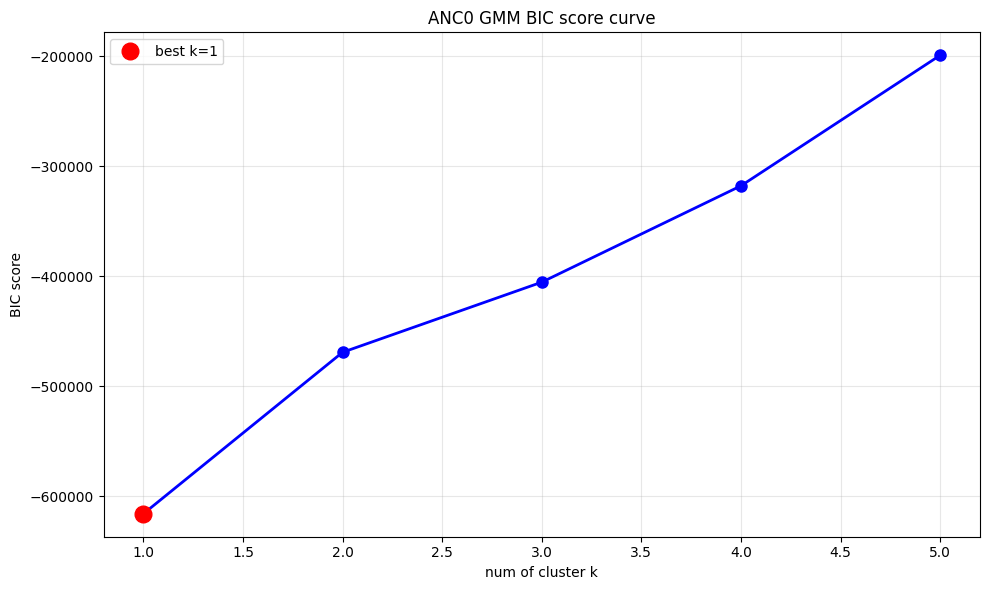

GMM聚类结果: 2个聚类
各聚类大小: [973  27]


In [7]:
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
new_contacts, lost_contacts = get_critical_contacts(chemokine_pdb, alternate_pdb,threshold=10.0,remove_diag=5)
critical_contacts = new_contacts + lost_contacts
print(f"新形成接触: {len(new_contacts)} 个")
print(f"断开接触: {len(lost_contacts)} 个")


anc0_seqs_path = f"/yezhirui/evo_probe/data/sample/node499_anc0_samples.fasta"
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")
anc0_contact_embedding = generate_contact_embedding(anc0_seqs_path, critical_contacts , mj_dict)
print(f"contact_embedding shape: {anc0_contact_embedding.shape}")

anc1_seqs_path = f"/yezhirui/evo_probe/data/sample/node500_anc1_samples.fasta"
anc1_contact_embedding = generate_contact_embedding(anc1_seqs_path, critical_contacts , mj_dict)

anc2_seqs_path = f"/yezhirui/evo_probe/data/sample/node501_anc2_samples.fasta"
anc2_contact_embedding = generate_contact_embedding(anc2_seqs_path, critical_contacts , mj_dict)

anc3_seqs_path = f"/yezhirui/evo_probe/data/sample/node502_anc3_samples.fasta"
anc3_contact_embedding = generate_contact_embedding(anc3_seqs_path, critical_contacts , mj_dict)

anc4_seqs_path = f"/yezhirui/evo_probe/data/sample/node507_anc4_samples.fasta"
anc4_contact_embedding = generate_contact_embedding(anc4_seqs_path, critical_contacts , mj_dict)


# 分析anc0数据
print("=== ANC0 GMM分析 ===")
k_vals, bic_scores,  best_k = gmm_bic_analysis(anc0_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC0 GMM BIC score curve")


# 使用最优k值进行聚类
gmm_model, gmm_labels, gmm_probs = gmm_cluster_analysis(anc0_contact_embedding, 2)
print(f"GMM聚类结果: {len(np.unique(gmm_labels))}个聚类")
print(f"各聚类大小: {np.bincount(gmm_labels)}")


# clustering, best_eps, scan_results = auto_dbscan_clustering(anc0_contact_embedding, min_eps=5, max_eps=20, eps_step=1, min_samples=3, test_fraction=1, verbose=True)
    

contact_embedding shape: (1000, 244)
=== ANC1 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-527348.17		367753.24
2	-400967.84		408645.67
3	-333070.25		478779.48
4	-169343.83		500998.87
5	-38915.34		539867.23

最优k值: 1 (BIC = -527348.17)


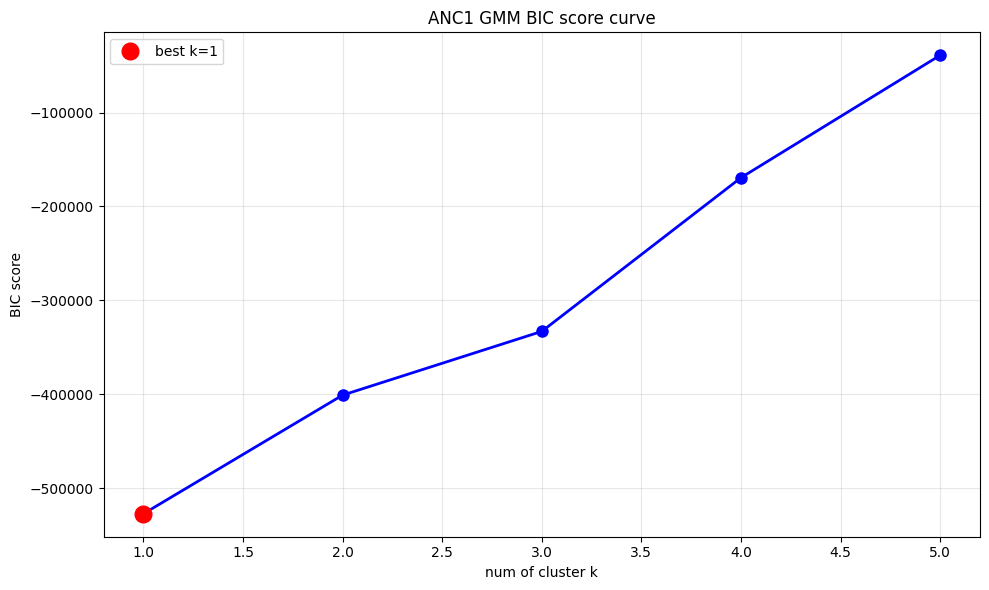

GMM聚类结果: 2个聚类
各聚类大小: [968  32]


In [ ]:
print("=== ANC1 GMM分析 ===")
k_vals, bic_scores, best_k = gmm_bic_analysis(anc1_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC1 GMM BIC score curve")

anc1_gmm_model, anc1_gmm_labels, anc1_gmm_probs = gmm_cluster_analysis(anc1_contact_embedding, 2)
print(f"GMM聚类结果: {len(np.unique(anc1_gmm_labels))}个聚类")
print(f"各聚类大小: {np.bincount(anc1_gmm_labels)}")



contact_embedding shape: (1000, 244)
=== ANC2 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-103842.86		156000.58
2	65042.54		175640.48
3	79675.87		272406.42
4	143651.76		344501.08
5	260029.11		390395.01

最优k值: 1 (BIC = -103842.86)


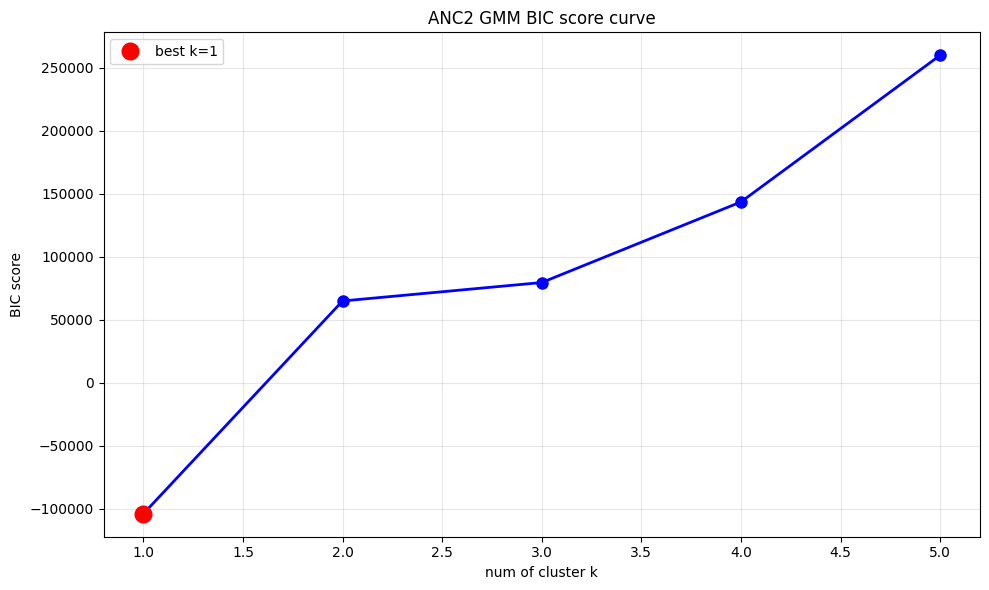

GMM聚类结果: 2个聚类
各聚类大小: [985  15]


In [ ]:
print("=== ANC2 GMM分析 ===")
k_vals, bic_scores, best_k = gmm_bic_analysis(anc2_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC2 GMM BIC score curve")

anc2_gmm_model, anc2_gmm_labels, anc2_gmm_probs = gmm_cluster_analysis(anc2_contact_embedding, 2)
print(f"GMM聚类结果: {len(np.unique(anc2_gmm_labels))}个聚类")
print(f"各聚类大小: {np.bincount(anc2_gmm_labels)}")

contact_embedding shape: (1000, 244)
=== ANC3 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-901805.42		554981.86
2	-1021769.14		719046.32
3	-781473.14		702980.92
4	-583244.90		707949.41
5	-426278.26		733548.69

最优k值: 2 (BIC = -1021769.14)


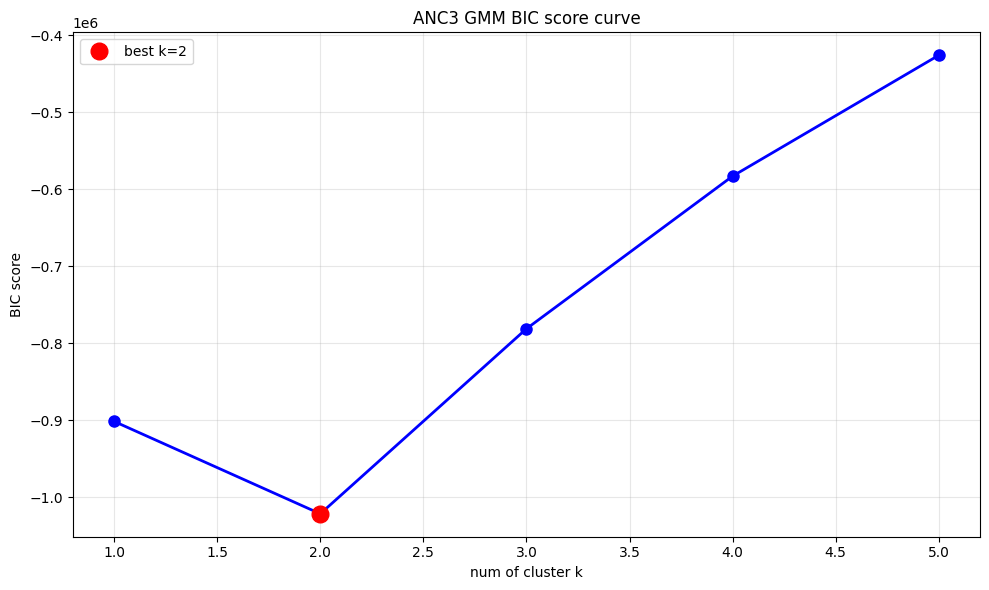

GMM聚类结果: 2个聚类
各聚类大小: [856 144]


In [19]:
anc3_seqs_path = f"/yezhirui/evo_probe/data/sample/node502_anc3_samples.fasta"
anc3_contact_embedding = generate_contact_embedding(anc3_seqs_path, critical_contacts , mj_dict)
print(f"contact_embedding shape: {anc3_contact_embedding.shape}")
# 分析anc0数据
print("=== ANC3 GMM分析 ===")
k_vals, bic_scores, best_k = gmm_bic_analysis(anc3_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC3 GMM BIC score curve")

anc3_gmm_model, anc3_gmm_labels, anc3_gmm_probs = gmm_cluster_analysis(anc3_contact_embedding, 2)
print(f"GMM聚类结果: {len(np.unique(anc3_gmm_labels))}个聚类")
print(f"各聚类大小: {np.bincount(anc3_gmm_labels)}")


contact_embedding shape: (1000, 244)
=== ANC4 GMM分析 ===
k	BIC分数		对数似然
-----------------------------------
1	-1841735.21		1024946.75
2	-1736983.10		1076653.30
3	-1736764.14		1180626.42
4	-1549278.18		1190966.05
5	-1367044.58		1203931.85

最优k值: 1 (BIC = -1841735.21)


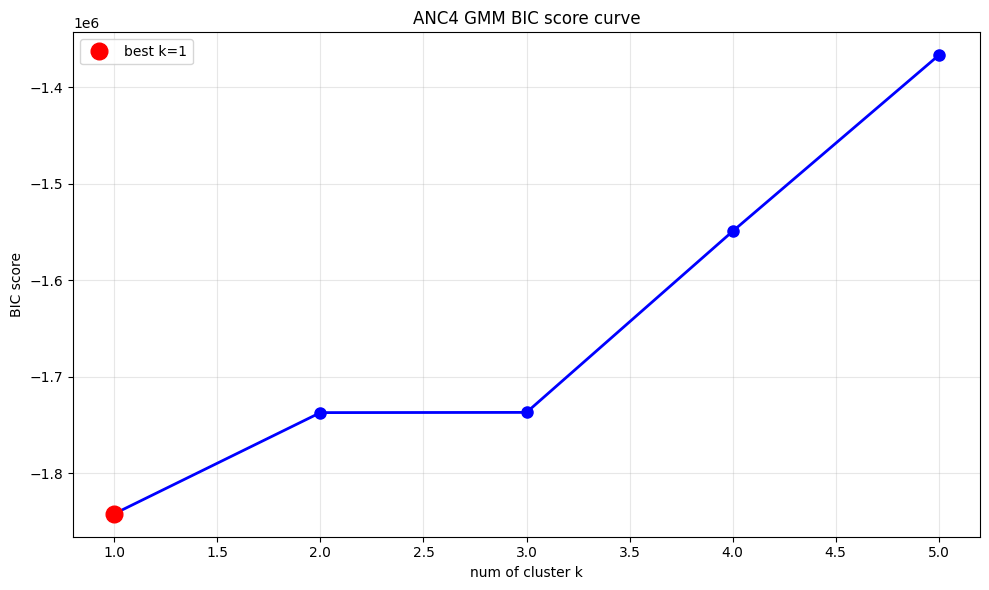

GMM聚类结果: 2个聚类
各聚类大小: [234 766]


In [20]:
anc4_seqs_path = f"/yezhirui/evo_probe/data/sample/node507_anc4_samples.fasta"
anc4_contact_embedding = generate_contact_embedding(anc4_seqs_path, critical_contacts , mj_dict)
print(f"contact_embedding shape: {anc4_contact_embedding.shape}")
# 分析anc0数据
print("=== ANC4 GMM分析 ===")
k_vals, bic_scores, best_k = gmm_bic_analysis(anc4_contact_embedding, max_k=5, verbose=True)

# 绘制BIC曲线
plot_bic_curve(k_vals, bic_scores, "ANC4 GMM BIC score curve")

anc4_gmm_model, anc4_gmm_labels, anc4_gmm_probs = gmm_cluster_analysis(anc4_contact_embedding, 2)
print(f"GMM聚类结果: {len(np.unique(anc4_gmm_labels))}个聚类")
print(f"各聚类大小: {np.bincount(anc4_gmm_labels)}")


In [ ]:

visualize_point_cloud(
    anc0_contact_embedding, 
    method='umap',
    title='ANC0 - umap visualization',
    figsize=(10, 8)
)



create_3d_visualization(
    anc0_contact_embedding,
    method='umap',
    title='ANC0 - 3D umap visualization'
)

In [ ]:

visualize_point_cloud(
    anc3_contact_embedding, 
    labels=anc3_gmm_labels,
    method='umap',
    title='ANC3 - umap visualization',
    figsize=(10, 8)
)



create_3d_visualization(
    anc3_contact_embedding,
    labels=anc3_gmm_labels,
    method='umap',
    title='ANC3 - 3D umap visualization'
)

In [ ]:

visualize_point_cloud(
    anc4_contact_embedding, 
    labels=anc4_gmm_labels,
    method='umap',
    title='ANC4 - umap visualization',
    figsize=(10, 8)
)



create_3d_visualization(
    anc4_contact_embedding,
    labels=anc4_gmm_labels,
    method='umap',
    title='ANC4 - 3D umap visualization'
)


dataset: ANC0
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [973  27]
BIC分数: -469178.24

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 19.7300

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-150.5095, 515.5143]

步骤4: 执行Hartigan's Dip Test...
Dip统计量: 0.012714
p值: 0.359484

=== 结论 ===
统计结论: single-modal
详细解释: 无法拒绝单峰假设，数据可能是单模态的

dataset: ANC1
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [968  32]
BIC分数: -400967.84

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 11.9652

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-68.6043, 234.6003]

步骤4: 执行Hartigan's Dip Test...
Dip统计量: 0.019714
p值: 0.009491

=== 结论 ===
统计结论: multi-modal
详细解释: 拒绝单峰假设，数据显示显著的多模态特征

dataset: ANC2
shape: (1000, 244)
=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投

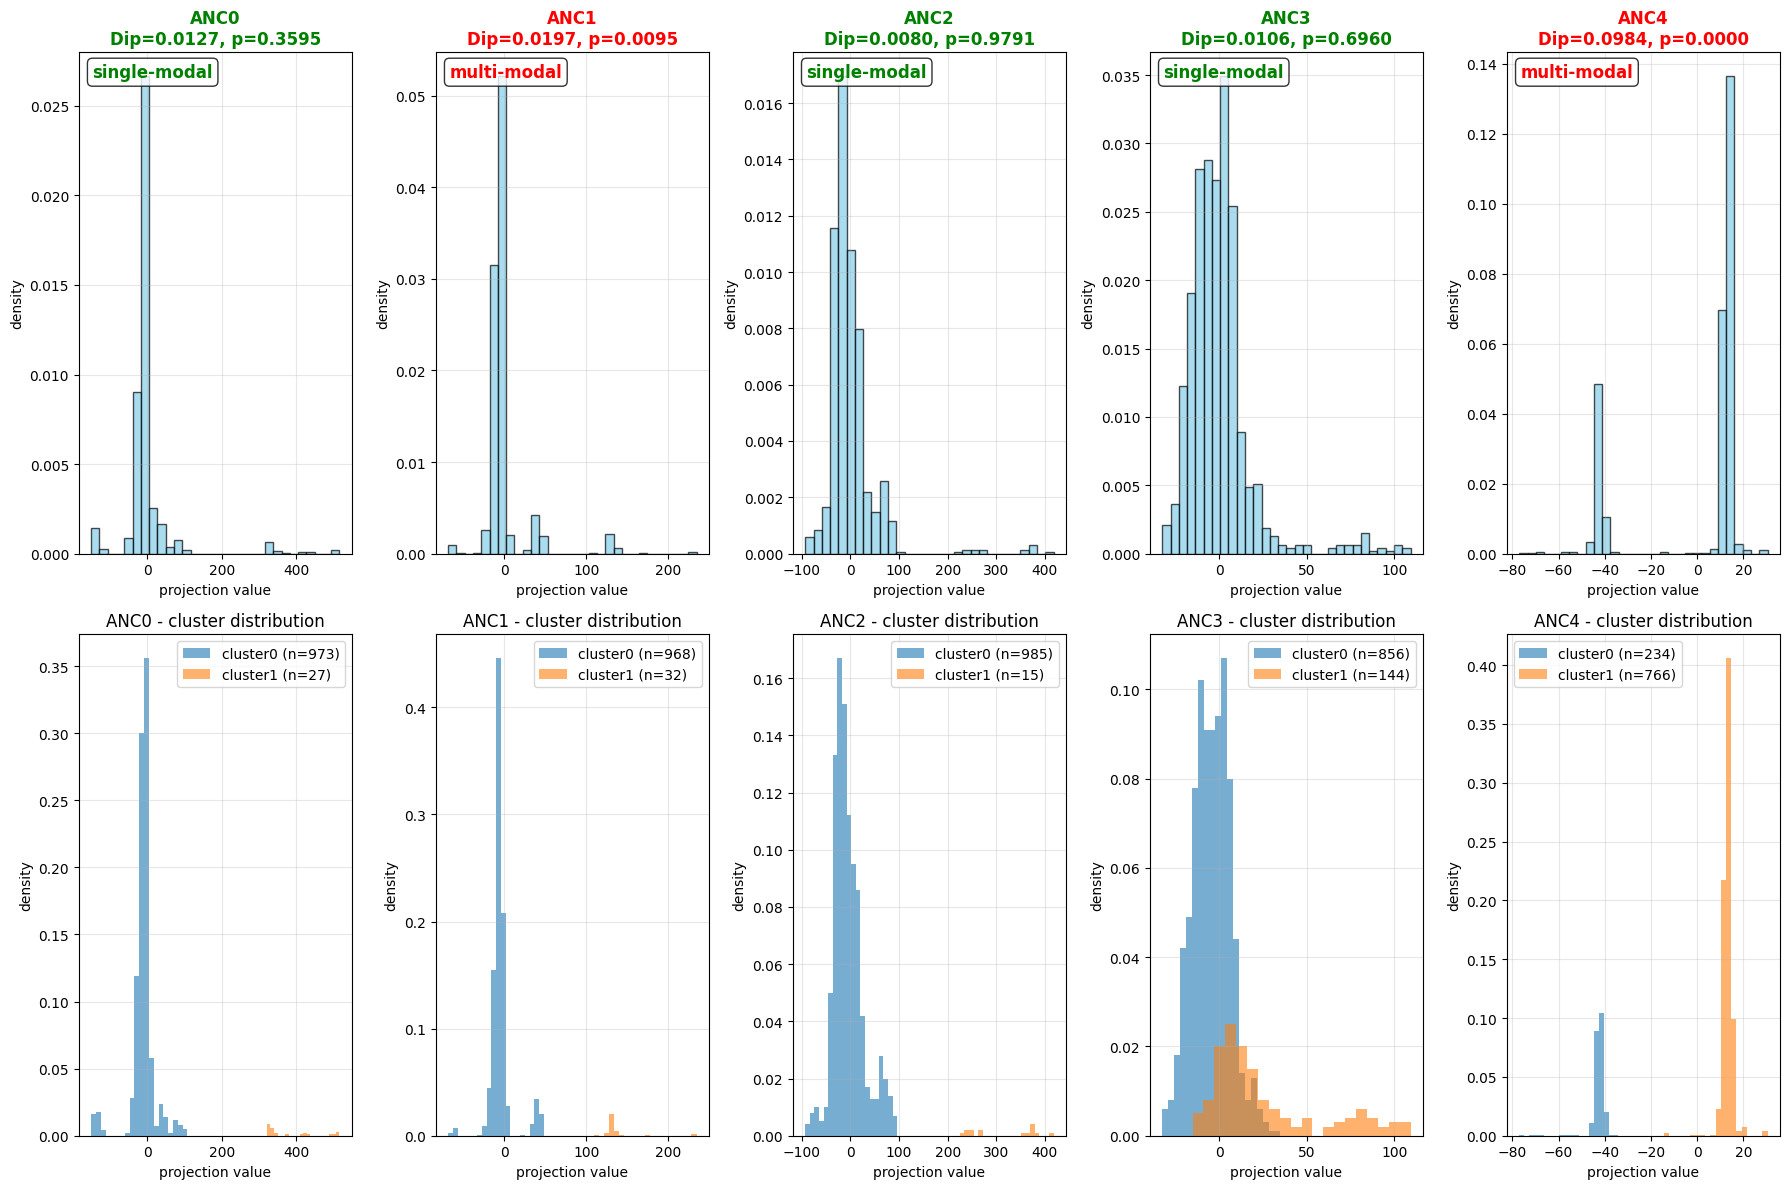


汇总结果表格:
数据集        Dip统计量       p值         结论         BIC分数       
--------------------------------------------------------------------------------
ANC0       0.012714     0.359484   单峰         -469178.24  
ANC1       0.019714     0.009491   多峰         -400967.84  
ANC2       0.007968     0.979069   单峰         65042.54    
ANC3       0.010555     0.696011   单峰         -1021769.14 
ANC4       0.098379     0.000000   多峰         -1736983.10 

=== ANC3详细结果 ===
投影向量模长: 5.4863
两个中心点距离: 5.4863
聚类确定性: 平均最大概率 = 1.000


In [21]:
# print("=== ANC3 GMM指导的Dip Test ===")
# anc3_results = gmm_guided_dip_test(
#     anc3_contact_embedding, 
#     k=2,  # 强制使用k=2来找到最佳分离方向
#     visualize=True,
#     figsize=(15, 5)
# )

# 2. 对所有数据集进行比较
datasets = {
    'ANC0': anc0_contact_embedding,
    'ANC1': anc1_contact_embedding,
    'ANC2': anc2_contact_embedding,
    'ANC3': anc3_contact_embedding,
    'ANC4': anc4_contact_embedding
}

all_results = compare_gmm_guided_dip_tests(
    datasets,
    k=2,
    figsize=(18, 12)
)

# 3. 详细查看某个数据集的结果
print("\n=== ANC3详细结果 ===")
anc3_result = all_results['ANC3']
print(f"投影向量模长: {np.linalg.norm(anc3_result['projection_vector']):.4f}")
print(f"两个中心点距离: {np.linalg.norm(anc3_result['center_B'] - anc3_result['center_A']):.4f}")
print(f"聚类确定性: 平均最大概率 = {np.mean(np.max(anc3_result['probabilities'], axis=1)):.3f}")

In [15]:
anc2_results = gmm_guided_dip_test(
    anc2_contact_embedding, 
    k=2,  # 强制使用k=2来找到最佳分离方向
    visualize=False
)

anc2_V=anc2_results['projection_vector']
_, top_contacts =  get_top_values_by_indices(anc2_V, critical_contacts, 10)
print(top_contacts)


# anc3_results = gmm_guided_dip_test(
#     anc3_contact_embedding, 
#     k=2,  # 强制使用k=2来找到最佳分离方向
#     visualize=False
# )

# anc3_V=anc3_results['projection_vector']
# top_indices = np.argsort(anc3_V)[-10:][::-1]
# top_values = anc3_V[top_indices]
# print(top_indices)
# print(top_values)



# anc4_results = gmm_guided_dip_test(
#     anc4_contact_embedding, 
#     k=2,  # 强制使用k=2来找到最佳分离方向s
#     visualize=False
# )

# anc4_V=anc4_results['projection_vector']
# top_indices = np.argsort(anc4_V)[-10:][::-1]
# top_values = anc4_V[top_indices]
# print(top_indices)
# print(top_values)







=== 基于GMM指导的Dip Test (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-93.1752, 418.0281]

步骤4: 执行Hartigan's Dip Test...
Dip统计量: 0.007968
p值: 0.979069

=== 结论 ===
统计结论: single-modal
详细解释: 无法拒绝单峰假设，数据可能是单模态的
[[16 49]
 [16 48]
 [16 43]
 [16 47]
 [19 43]
 [16 44]
 [15 43]
 [33 57]
 [33 58]
 [19 42]]
